# Waste Classification with Deep Learning

## Project Overview
This project tackles waste classification using a deep learning-based approach that combines both images and text descriptions. The goal is to help automate the sorting of trash by predicting the correct category—like recyclable, compostable, or special disposal—based on an image and a short description.

### How Does It Work?
- We use a Convolutional Neural Network (CNN) (ResNet18) to analyze images of waste items.
- A Bidirectional LSTM (BiLSTM) with word embeddings is used to process text descriptions of waste.
- Features from both the image and text are combined to make the final classification.
- The model is trained in **PyTorch** and optimized using the Adam optimizer.


In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from torchvision.models import ResNet18_Weights
from PIL import Image
import pandas as pd
import numpy as np
import torch.nn.init as init
from tqdm import tqdm
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# Set the device (Use GPU if available, otherwise default to CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Computation will run on: {device}")

Computation will run on: cuda


## Creating a Custom Dataset for Waste Classification

Since our model processes both images and text descriptions, we need a custom PyTorch dataset class that:
- Loads images from different waste categories (Blue, Black, Green, TTr).
- Extracts text descriptions from filenames and converts them into numerical representations.
- Applies image transformations to help the model generalize better.
- Ensures that both image and text inputs are properly formatted before feeding them into the model.

### 🔹 How It Works
- The dataset reads images from four main caegories:  
  Blue (0), Black (1), Green (2), and TTr (3).
- Each image filename contains a short text description, which we tokenize into numbers using a custom vocabulary.
- Text sequences are padded or truncated to a fixed length to maintain consistency.
- When a sample is requested, the dataset returns:
  1. The processed image tensor.
  2. The numerical text representation.
  3. The corresponding waste category label.

In [2]:
# Custom dataset class for handling both images and text descriptions
class WasteDataset(Dataset):
    def __init__(self, data_dir, transform=None, vocabulary=None, max_text_len=5):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.text_data = []
        self.max_text_len = max_text_len
        self.vocabulary = vocabulary if vocabulary else {}

        # Define category labels in the order: Blue → Black → Green → TTr
        label_mapping = {"Blue": 0, "Black": 1, "Green": 2, "TTR": 3}

        # Load all images and extract text descriptions
        for category, label_idx in label_mapping.items():
            category_path = os.path.join(data_dir, category)
            if not os.path.isdir(category_path):
                continue  # Skip if folder doesn't exist
            
            for file_name in os.listdir(category_path):
                img_path = os.path.join(category_path, file_name)
                self.image_paths.append(img_path)
                self.labels.append(label_idx)

                # Extract words from filename (assumes words are separated by underscores)
                words = file_name.split('.')[0].split('_')
                text_indices = [self._word_to_index(word) for word in words]

                # 🔹 Pad or truncate text sequence to a fixed length
                if len(text_indices) < self.max_text_len:
                    text_indices += [0] * (self.max_text_len - len(text_indices))
                else:
                    text_indices = text_indices[:self.max_text_len]

                self.text_data.append(text_indices)

    def _word_to_index(self, word):
        if word not in self.vocabulary:
            self.vocabulary[word] = len(self.vocabulary)
        return self.vocabulary[word]

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        text_indices = self.text_data[idx]
        
        # Load and process the image
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(text_indices), torch.tensor(label)



## Data Preprocessing & Transformations

Before feeding data into our deep learning model, we need to ensure it's in a consistent format. Since we're working with both images and text, we apply different preprocessing techniques to each.

### Image Preprocessing
To improve our model's ability to recognize waste items under different conditions, we apply:
- **Resizing:** Standardizes images to a fixed `224x224` resolution.
- **Random Cropping & Augmentation (Training Only):** Helps prevent overfitting by introducing variations like flips and rotations.
- **Normalization:** Scales pixel values to the range `[0,1]` and applies standard ImageNet normalization.

### Text Preprocessing
For text descriptions, we:
- **Convert words to lowercase** to maintain consistency.
- **Tokenize the text** into individual words.
- **Convert words to numerical indices** using a vocabulary dictionary.
- **Pad or truncate sentences** to a fixed length (5 words) to ensure uniform input size.


In [3]:
# Define dataset paths (Modify this based on your system)
BASE_PATH = "/work/TALC/enel645_2025w/garbage_data"
TRAIN_DIR = os.path.join(BASE_PATH, "CVPR_2024_dataset_Train")
VAL_DIR = os.path.join(BASE_PATH, "CVPR_2024_dataset_Val")
TEST_DIR = os.path.join(BASE_PATH, "CVPR_2024_dataset_Test")

# Image transformations for training (with augmentation) and validation/testing
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [4]:
train_dataset = WasteDataset(TRAIN_DIR, transform=train_transform)
val_dataset = WasteDataset(VAL_DIR, transform=test_transform, vocabulary=train_dataset.vocabulary)
test_dataset = WasteDataset(TEST_DIR, transform=test_transform, vocabulary=train_dataset.vocabulary)

# Define batch size and number of workers
BATCH_SIZE = 64
NUM_WORKERS = 4

# Adjusting num_workers based on system recommendation
import multiprocessing
NUM_WORKERS = min(2, multiprocessing.cpu_count())  # Limit workers to 2 or available CPUs

# Create DataLoaders with updated num_workers
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# Print confirmation
print(f"Using {NUM_WORKERS} worker(s) for DataLoader.")

# Display dataset sizes
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Testing samples: {len(test_dataset)}")


Using 2 worker(s) for DataLoader.
Training samples: 11629
Validation samples: 1800
Testing samples: 3432


## Designing the Waste Classification Model

Since our classification system relies on both images and text descriptions, we need a model that can effectively process both modalities and make a decision. This means using:
- A Convolutional Neural Network (CNN) to extract patterns from images.
- A Bidirectional LSTM (BiLSTM) to interpret text descriptions.
- A Fusion Layer to combine the extracted features from both inputs.
- A Softmax Output Layer to classify the waste into one of four categories.

This model has two main parts:  
**Image Processing**  
   - We use ResNet18, a well-known CNN model, to extract features from images.  
   - The model has been pretrained on ImageNet, so it already recognizes general patterns.  
   - The last fully connected layer is replaced to match our required feature dimensions.  
   - Earlier layers are frozen to retain useful pretrained knowledge.  

**Text Processing**  
   - The text descriptions are first converted into word embeddings (vectors that represent words numerically).  
   - These embeddings are passed through a Bidirectional LSTM to learn relationships between words.  
   - To ensure important words get more attention, we include an attention mechanism (optional).  
   - The output of the LSTM is processed using a fully connected layer to create a meaningful representation of the text.  

**Fusion & Classification**  
   - The extracted image and text features are combined into a single representation.  
   - A dropout layer is used to prevent overfitting.  
   - The final fully connected layer uses a softmax activation to predict the most likely waste category.  


In [5]:
class WasteClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=256, num_classes=4, dropout_rate=0.5):
        
        super(WasteClassifier, self).__init__()
        
        # Load Pretrained ResNet18 and modify final layer
        self.cnn = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.cnn.fc = nn.Linear(self.cnn.fc.in_features, hidden_dim)
        
        # Freeze all CNN layers except last block
        for param in self.cnn.parameters():
            param.requires_grad = False
        for param in self.cnn.layer4.parameters():
            param.requires_grad = True

        # Text processing layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.text_fc = nn.Linear(hidden_dim * 2, hidden_dim)  # BiLSTM output has 2x hidden_dim
        self.dropout = nn.Dropout(dropout_rate)

        # Fully connected layer for final classification
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, image, text):
        # Image feature extraction
        image_features = self.cnn(image)
        
        # Text processing through embedding and LSTM
        text_embedded = self.embedding(text)
        lstm_out, _ = self.lstm(text_embedded)
        
        # Attention mechanism (optional, can be removed if needed)
        attention_weights = torch.softmax(torch.sum(lstm_out, dim=2), dim=1)
        text_features = torch.sum(lstm_out * attention_weights.unsqueeze(-1), dim=1)

        # Fully connected text layer
        text_features = self.text_fc(text_features)
        text_features = self.dropout(text_features)

        # Concatenate image and text features
        combined_features = torch.cat((image_features, text_features), dim=1)
        combined_features = self.dropout(combined_features)

        # Classification layer
        output = self.fc(combined_features)
        return output


In [6]:
# Get vocabulary size
vocab_size = len(train_dataset.vocabulary)

# Initialize model
model = WasteClassifier(vocab_size).to(device)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.003, weight_decay=0.0006)
criterion = nn.CrossEntropyLoss()

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.65)

# Print model summary
print(model)


WasteClassifier(
  (cnn): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

## Training & Evaluating the Model

To train the waste classification model, we follow these steps:

 **Forward Pass:** The model takes an image and text description, processes them through CNN and LSTM, and generates predictions.  
 **Calculate Loss:** The model compares its predictions to the correct waste category using CrossEntropyLoss.  
 **Backward Pass & Optimization:** The optimizer updates the model’s parameters to reduce the error.  
 **Repeat for Multiple Epochs:** The model gradually improves as it sees more data.  
 **Validation Step:** After each epoch, we test the model on validation data to ensure it's learning properly.

### How We Measure Performance
We use several key metrics to evaluate the model:
- **Accuracy:** Percentage of correctly classified samples.  
- **F1-Score:** Balances precision and recall to measure overall model quality.  
- **Loss Value:** Indicates how far the predictions are from the actual labels (lower is better).  

### Early Stopping: Preventing Overfitting
- If the validation loss **doesn’t improve for several epochs**, we stop training early.
- This prevents the model from memorizing the training data instead of generalizing.

---


In [7]:
def train_model(model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs=15, patience=2):
    """
    Function to train and validate the model.
    Returns:
        model: Trained model.
    """
    best_val_loss = float("inf")
    patience_counter = 0  # Track how many epochs validation loss does not improve

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # Training Phase
        model.train()
        total_loss = 0
        correct, total = 0, 0

        for images, descriptions, labels in tqdm(train_loader, desc="Training"):
            images, descriptions, labels = images.to(device), descriptions.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images, descriptions)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = total_loss / len(train_loader)
        train_accuracy = correct / total

        # Validation Phase
        model.eval()
        val_loss = 0
        correct, total = 0, 0

        with torch.no_grad():
            for images, descriptions, labels in tqdm(val_loader, desc="Validation"):
                images, descriptions, labels = images.to(device), descriptions.to(device), labels.to(device)
                outputs = model(images, descriptions)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_loss /= len(val_loader)
        val_accuracy = correct / total

        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        # Learning rate adjustment
        scheduler.step()

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pth")  # Save best model
            print("Model improved, saving...")
        else:
            patience_counter += 1
            print(f"Early stopping counter: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    return model


In [8]:
trained_model = train_model(model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs=15, patience=3)



Epoch 1/15


Validation: 100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Train Loss: 0.6918, Train Accuracy: 0.7355
Val Loss: 0.5924, Val Accuracy: 0.7761
Model improved, saving...

Epoch 2/15


Validation: 100%|██████████| 29/29 [01:06<00:00,  2.30s/it]


Train Loss: 0.5218, Train Accuracy: 0.8083
Val Loss: 0.5110, Val Accuracy: 0.8150
Model improved, saving...

Epoch 3/15


Validation: 100%|██████████| 29/29 [01:05<00:00,  2.24s/it]


Train Loss: 0.4536, Train Accuracy: 0.8400
Val Loss: 0.4960, Val Accuracy: 0.8206
Model improved, saving...

Epoch 4/15


Validation: 100%|██████████| 29/29 [01:05<00:00,  2.27s/it]


Train Loss: 0.3552, Train Accuracy: 0.8755
Val Loss: 0.4429, Val Accuracy: 0.8500
Model improved, saving...

Epoch 5/15


Validation: 100%|██████████| 29/29 [01:05<00:00,  2.26s/it]


Train Loss: 0.3115, Train Accuracy: 0.8928
Val Loss: 0.4133, Val Accuracy: 0.8583
Model improved, saving...

Epoch 6/15


Validation: 100%|██████████| 29/29 [01:05<00:00,  2.27s/it]


Train Loss: 0.2760, Train Accuracy: 0.9107
Val Loss: 0.4089, Val Accuracy: 0.8517
Model improved, saving...

Epoch 7/15


Validation: 100%|██████████| 29/29 [01:05<00:00,  2.26s/it]


Train Loss: 0.1977, Train Accuracy: 0.9360
Val Loss: 0.4072, Val Accuracy: 0.8667
Model improved, saving...

Epoch 8/15


Validation: 100%|██████████| 29/29 [01:05<00:00,  2.28s/it]


Train Loss: 0.1599, Train Accuracy: 0.9490
Val Loss: 0.4435, Val Accuracy: 0.8533
Early stopping counter: 1/3

Epoch 9/15


Validation: 100%|██████████| 29/29 [01:07<00:00,  2.32s/it]


Train Loss: 0.1218, Train Accuracy: 0.9592
Val Loss: 0.4828, Val Accuracy: 0.8522
Early stopping counter: 2/3

Epoch 10/15


Validation: 100%|██████████| 29/29 [01:06<00:00,  2.30s/it]

Train Loss: 0.0776, Train Accuracy: 0.9776
Val Loss: 0.4987, Val Accuracy: 0.8544
Early stopping counter: 3/3
Early stopping triggered.


In [9]:
# Load the best saved model
model.load_state_dict(torch.load("best_model.pth", weights_only=True))
model.eval()  # Set to evaluation mode

print("Model loaded successfully and ready for testing!")


Model loaded successfully and ready for testing!


## Evaluating the Model on Test Data

After training, we need to check if our model is actually useful in real-world scenarios. This means testing it on a completely new set of data that it has never seen before.  
To get a full picture of how well the model is working, we use the following:
- **Accuracy** → Measures the percentage of correctly classified waste items.
- **F1-Score** → A balanced metric that considers both **precision** (how many of the predicted items were correct) and **recall** (how many actual items were detected correctly).
- **Classification Report** → Provides a detailed breakdown of how well the model performed for each waste category.

In [16]:
# Initialize lists for storing results
all_labels, all_predictions = [], []
misclassified_images = []  # Store misclassified samples

# Run inference on the test set
with torch.no_grad():
    for images, descriptions, labels in tqdm(test_loader, desc="Running Predictions"):
        images, descriptions, labels = images.to(device), descriptions.to(device), labels.to(device)

        # Generate predictions
        outputs = model(images, descriptions)
        _, preds = torch.max(outputs, 1)

        # Track results
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(preds.cpu().numpy())

        # Store misclassified samples for analysis
        for i in range(len(labels)):
            if preds[i] != labels[i]:  # If incorrect prediction
                misclassified_images.append((images[i].cpu(), labels[i].cpu(), preds[i].cpu()))

# Compute Accuracy & Classification Report
accuracy = np.mean(np.array(all_labels) == np.array(all_predictions))
print(f"\n Final Test Accuracy: {accuracy * 100:.2f}%")

print("\n Classification Report:")
print(classification_report(all_labels, all_predictions))


Running Predictions: 100%|██████████| 54/54 [02:07<00:00,  2.35s/it]


 Final Test Accuracy: 80.57%

 Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.91      0.82      1086
           1       0.74      0.61      0.67       695
           2       0.91      0.88      0.89       799
           3       0.87      0.76      0.81       852

    accuracy                           0.81      3432
   macro avg       0.81      0.79      0.80      3432
weighted avg       0.81      0.81      0.80      3432



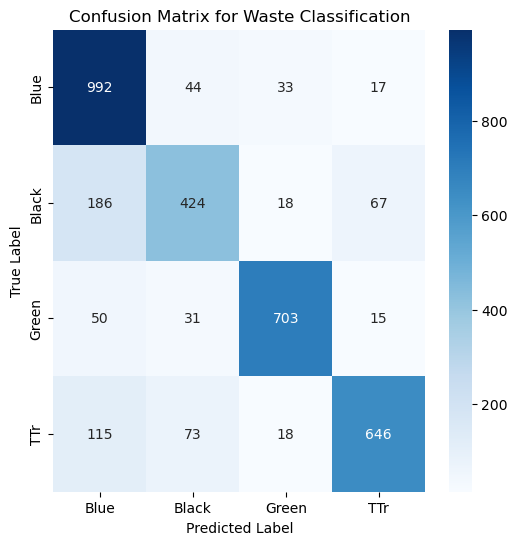

In [18]:

# Generate Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Define Class Names (Adjust if needed)
class_names = ["Blue", "Black", "Green", "TTr"]

# Plot the Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Waste Classification")

# Show the plot
plt.show()


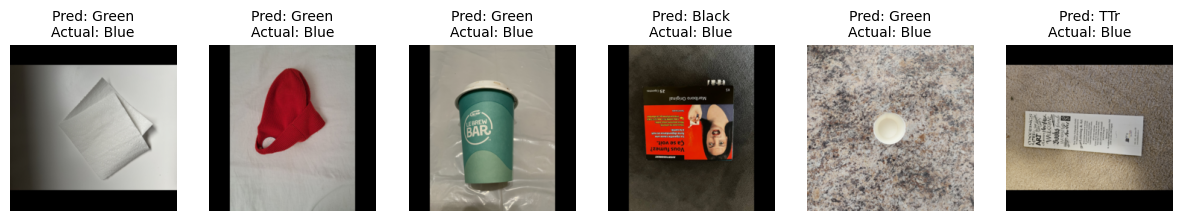

In [17]:
# To Display Misclassified Images
def show_misclassified_samples(misclassified_images, class_names, num_samples=6):
    num_samples = min(len(misclassified_images), num_samples)  # Avoid index errors
    if num_samples == 0:
        print("No misclassified images found!")
        return

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

    for i in range(num_samples):
        image, actual_label, predicted_label = misclassified_images[i]
        image = image.numpy().transpose((1, 2, 0))  # Convert tensor to image format

        # Denormalize image (reverse normalization)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0, 1)

        # Plot misclassified image
        ax = axes[i]
        ax.imshow(image)
        ax.axis("off")
        ax.set_title(f"Pred: {class_names[predicted_label]}\nActual: {class_names[actual_label]}", fontsize=10)

    plt.show()

# Define Class Names
class_names = ["Blue", "Black", "Green", "TTr"]

# Show the first 6 misclassified images
show_misclassified_samples(misclassified_images, class_names, num_samples=6)
